In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from utils.utils import pretty_lat, pretty_lon, ProgressStatus, plot_n_steps_of_area_from_nc_file
from tempfile import TemporaryDirectory

In [2]:
from station.data_submission import DataSubmission
from station.station import StationData

from train_station_twin.training_executor import TrainingExecutor
from infilling.evaluation_executor import EvaluationExecutor
from infilling.infilling_writer import InfillingWriter

from era5.era5_for_station import DownloadEra5ForStation, DownloadEra5ForStationGaps
from era5.era5_download_hook import Era5DownloadHook
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [4]:
# Marshall Station but passing lat lon and year month to the hook 

era5_hook = Era5DownloadHook(lat=39.9496, lon=-105.196)

years = 2020
months = 6

era5_hook.download_month(years, months, "ERA5hook_marshall")



Using URL: https://cds-beta.climate.copernicus.eu/api


2024-10-31 12:09:15,347 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T in July 2024 - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-10-31 12:09:15,349 INFO Request ID is f25352f4-03ab-44fd-bf33-91b79e0eafdd
2024-10-31 12:09:15,824 INFO status has been updated to accepted
2024-10-31 12:09:19,849 INFO status has been updated to running
2024-10-31 12:09:23,339 INFO status has been updated to successful


In [ ]:
# Marshall Station but passing lat lon and year month to the hook 

era5_hook = Era5DownloadHook(lat=39.9496, lon=-105.196)

years = 2020
months = 6

era5_hook.download_month(years, months, "ERA5hook_marshall")


In [4]:
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc

folder = "ERA5hook_marshall_copy"
era5_target_file_path = f"{folder}/era5.nc"

# Conversion
Era5DataFromGribToNc(
    folder_path=folder,
    era5_target_file_path=era5_target_file_path
)




Found 2020_6.grib


PermissionError: [Errno 13] Permission denied: '/var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/tmp_1l13wx2/2020_6.nc'

In [10]:
ds = xr.open_dataset("ERA5hook_marshall/2020_6.nc")
ds


<xarray.Dataset> Size: 1MB
Dimensions:  (time: 720, lon: 9, lat: 9)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-06-01 ... 2020-06-30T23:00:00
  * lon      (lon) float64 72B 253.8 254.1 254.3 254.6 ... 255.3 255.6 255.8
  * lat      (lat) float64 72B 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2 38.95
Data variables:
    var167   (time, lat, lon) float32 233kB ...
    var228   (time, lat, lon) float32 233kB ...
    var165   (time, lat, lon) float32 233kB ...
    var166   (time, lat, lon) float32 233kB ...
    var134   (time, lat, lon) float32 233kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Thu Oct 31 13:24:08 2024: cdo -f nc4 copy ERA5hook_marshall...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

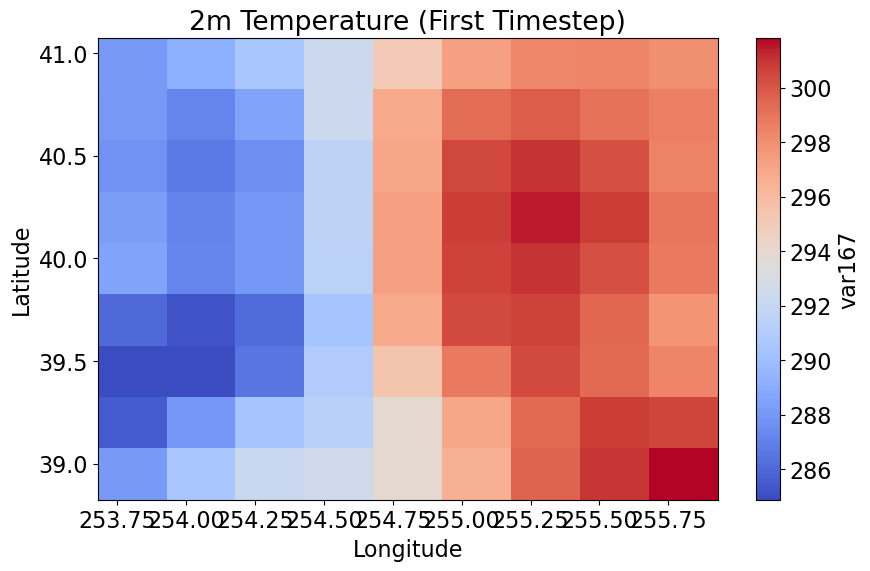

In [11]:
# Select the first timestep of 't2m' and plot it
t2m_first_timestep = ds['var167'].isel(time=-3)

# Plotting
plt.figure(figsize=(10, 6))
t2m_first_timestep.plot(cmap='coolwarm')
plt.title("2m Temperature (First Timestep)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

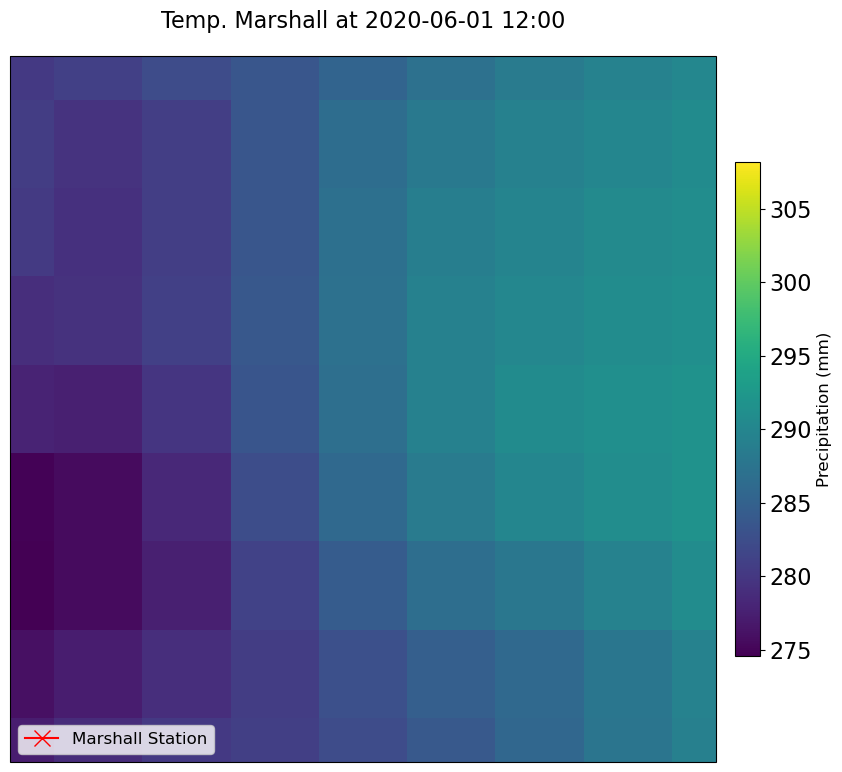

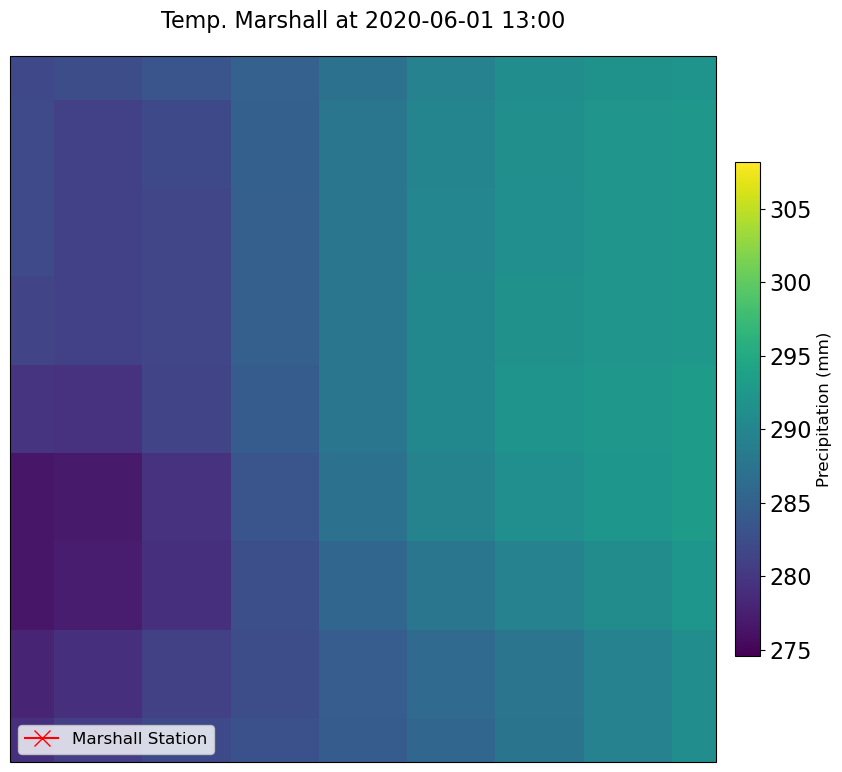

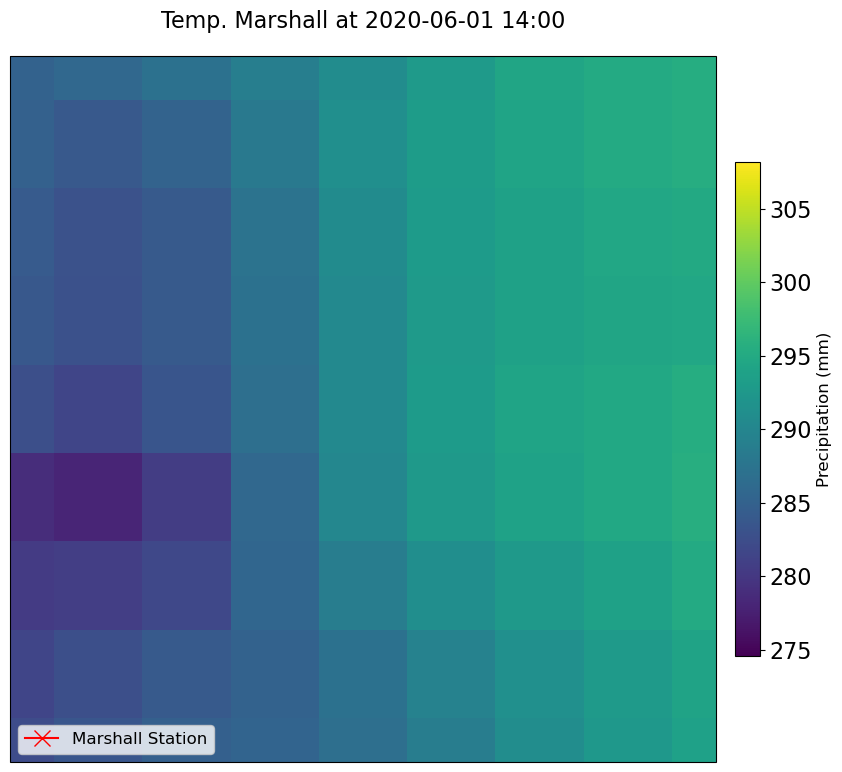

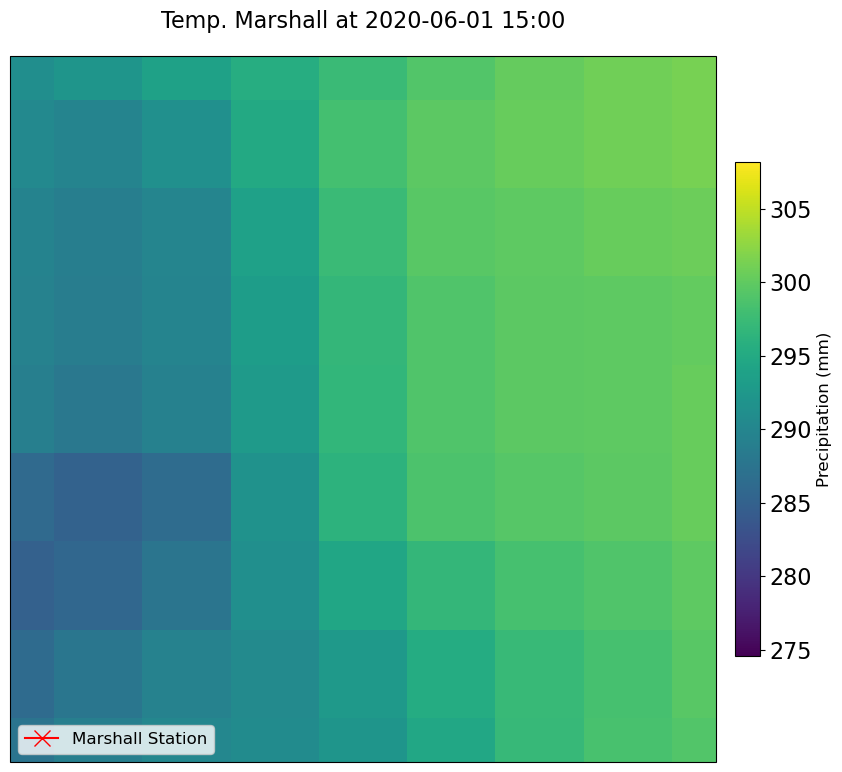

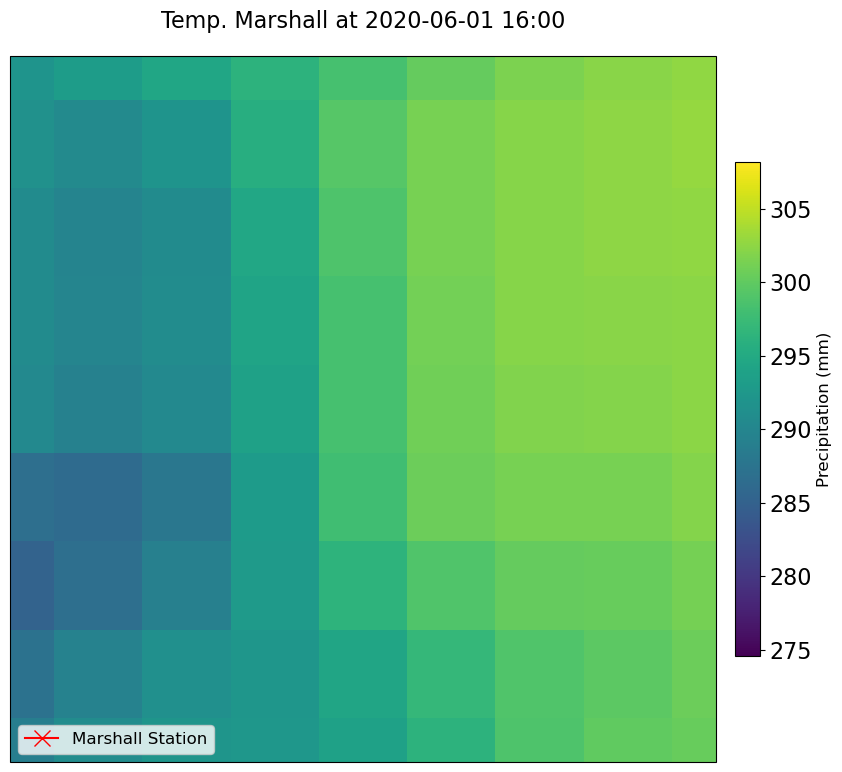

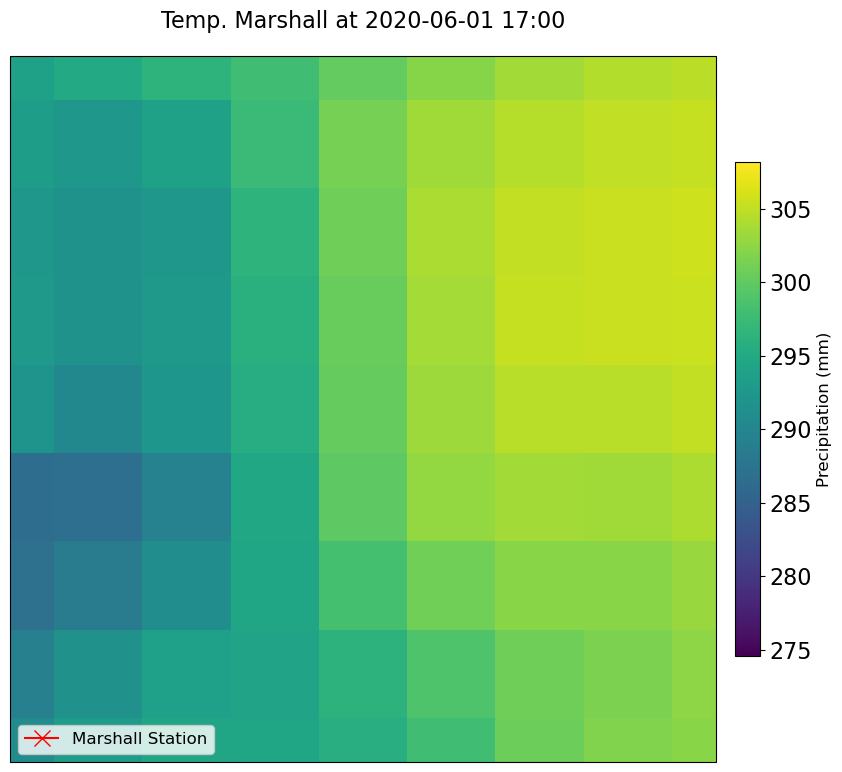

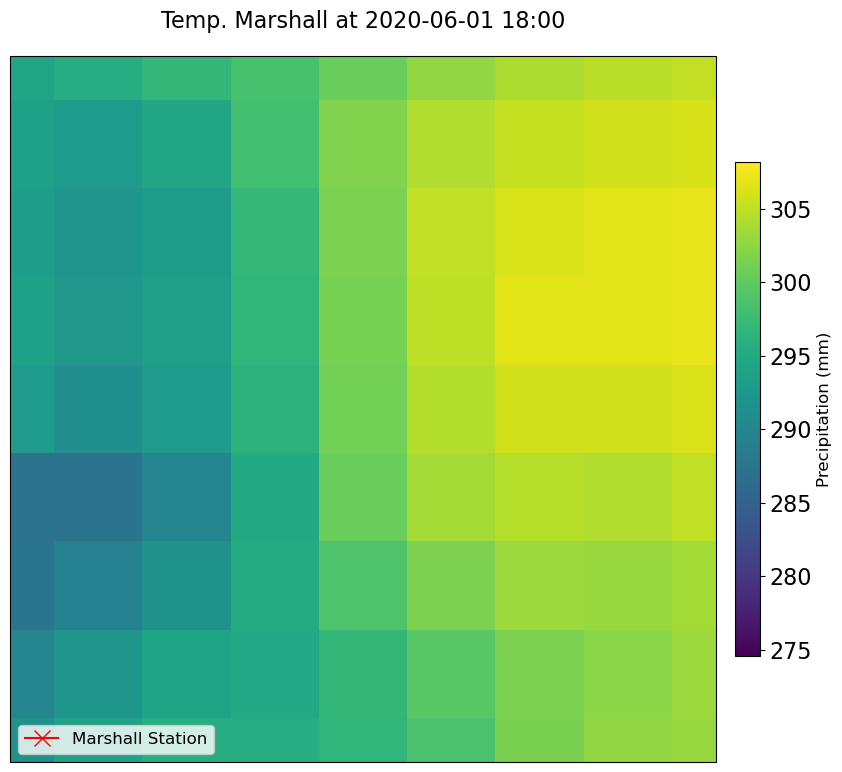

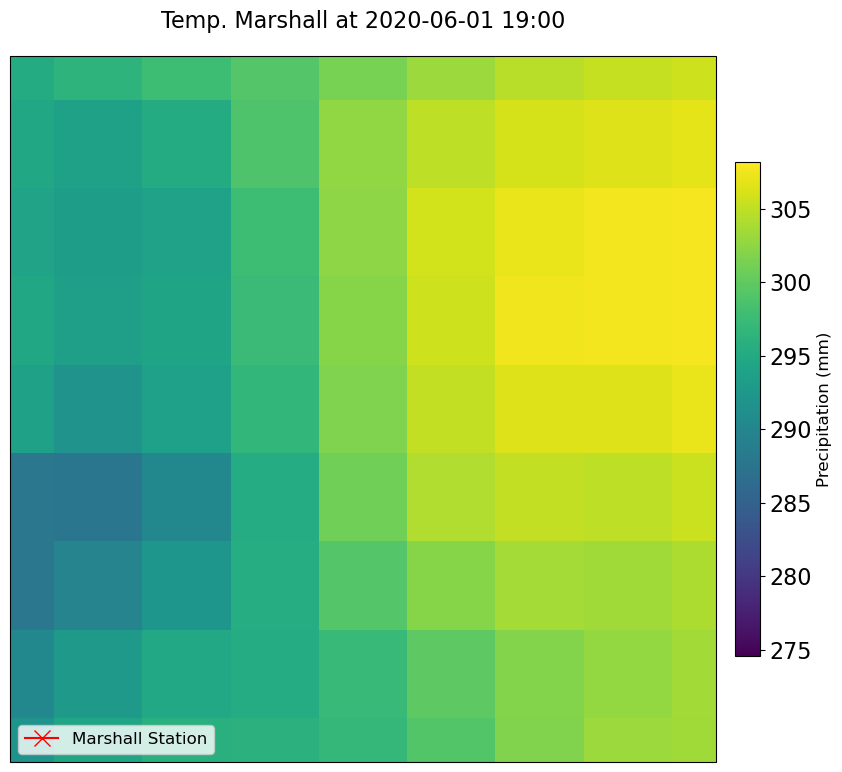

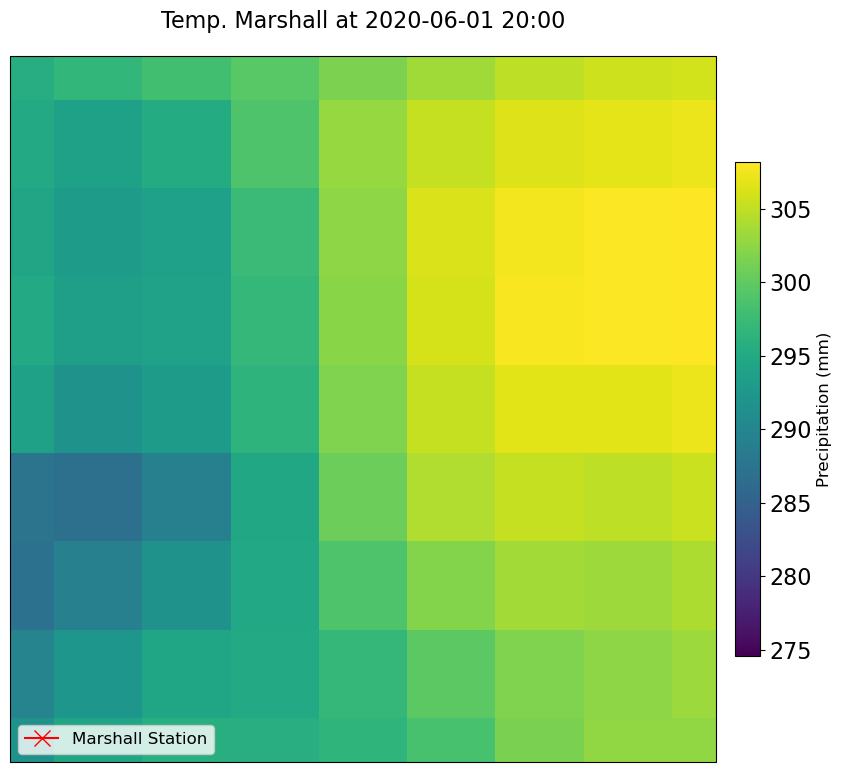

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Define the variable and coordinate names
var = 'var167'
lat = ds.lat.values
lon = ds.lon.values

# Coordinates of the specific point (Vienna Station)
point_lon = 39.9496
point_lat = -105.196

# Select the time range
selected_data = ds.sel(time=slice("2020-06-01 12:00", "2020-06-01 20:00"))

# Create a meshgrid for pcolormesh
Lon, Lat = np.meshgrid(lon, lat)

# Define plot parameters
cmap = 'viridis'
vmin = selected_data[var].min().item()
vmax = selected_data[var].max().item()
title_base = 'Temp. Marshall'

for t in selected_data.time:
    # Create a new figure with Cartopy's PlateCarree projection
    fig, ax = plt.subplots(
        figsize=(10, 8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    # Extract data for the current time step
    data = selected_data[var].sel(time=t).values
    
    # Handle missing or invalid data
    data = np.ma.masked_invalid(data)
    
    # Plot the data using pcolormesh
    pcm = ax.pcolormesh(
        Lon, Lat, data, 
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree()
    )
        # Set the map extent based on data

    
    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

    # Plot the specific point (Vienna Station)
    ax.plot(
        point_lon, point_lat,
        marker='x', color='red', markersize=12,
        transform=ccrs.PlateCarree(),
        label='Marshall Station'
    )

    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add a colorbar
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
    cbar.set_label('Precipitation (mm)', fontsize=12)
    
    # Set title with time information
    time_str = pd.to_datetime(t.values).strftime('%Y-%m-%d %H:%M')
    plt.title(f'{title_base} at {time_str}', fontsize=16, pad=20)
    
    # Add legend for the Vienna Station marker
    ax.legend(loc='lower left', fontsize=12)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)